In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# !pip install pandas-ml-utils

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# Utilities
# from viz_utils import *
# from custom_transformers import *
# from ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [ ]:
# !npm install vis-utils

In [3]:
raw_path = '/content/drive/MyDrive/Marketing/data/'
olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')



##Basic overview

In [4]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

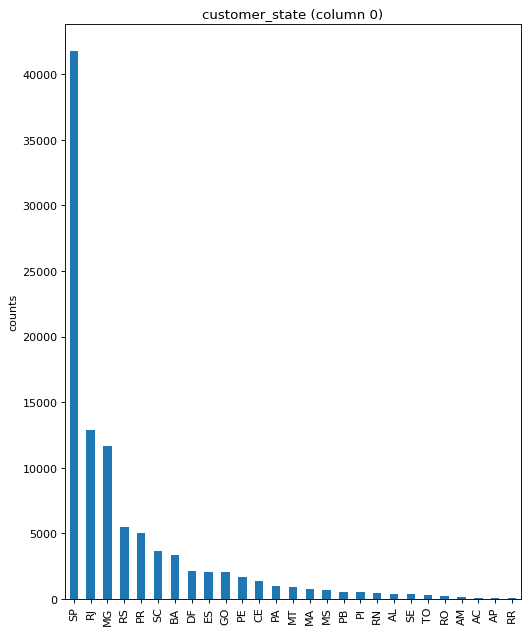

In [5]:
plotPerColumnDistribution(olist_customer, 10, 5)

In [6]:
df = olist_orders.merge(olist_customer, on="customer_id") 
df = df.merge(olist_order_items, on="order_id")
df

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3       949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4       ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                  ...                               ...   
112645  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
112646  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
112647  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
112648  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
112649  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_status order_purchase_timestamp    order_approved_at  \
0         delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1         delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2         delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3         delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4         delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...             ...                      ...                  ...   
112645    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
112646    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
112647    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
112648    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
112649    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-10-04 19:55:00           2017-10-10 21:25:13   
1               2018-07-26 14:31:00           2018-08-07 15:27:45   
2               2018-08-08 13:50:00           2018-08-17 18:06:29   
3               2017-11-22 13:39:59           2017-12-02 00:28:42   
4               2018-02-14 19:46:34           2018-02-16 18:17:02   
...                             ...                           ...   
112645          2018-02-07 23:22:42           2018-02-28 17:37:56   
112646          2017-08-28 20:52:26           2017-09-21 11:24:17   
112647          2018-01-12 15:35:03           2018-01-25 23:32:54   
112648          2018-01-12 15:35:03           2018-01-25 23:32:54   
112649          2018-03-09 22:11:59           2018-03-16 13:08:30   

       order_estimated_delivery_date                customer_unique_id  \
0                2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
1                2018-08-13 00:00:00  af07308b275d755c9edb36a90c618231   
2                2018-09-04 00:00:00  3a653a41f6f9fc3d2a113cf8398680e8   
3                2017-12-15 00:00:00  7c142cf63193a1473d2e66489a9ae977   
4                2018-02-26 00:00:00  72632f0f9dd73dfee390c9b22eb56dd6   
...                              ...                               ...   
112645           2018-03-02 00:00:00  da62f9e57a76d978d02ab5362c509660   
112646           2017-09-27 00:00:00  737520a9aad80b3fbbdad19b66b37b30   
112647           2018-02-15 00:00:00  5097a5312c8b157bb7be58ae360ef43c   
112648           2018-02-15 00:00:00  5097a5312c8b157bb7be58ae360ef43c   
112649           2018-04-03 00:00:00  60350aa974b26ff12caad89e55993bd6   

        customer_zip_code_prefix            customer_city customer_state  \
0                           3149                sao paulo             SP   
1                          47813                barreiras             BA   
2                          75265               vianopolis             GO   
3                          59296  sao goncalo do amarante             RN   
4                           9195              santo andre             SP   
...                          ...                      ...            ...   
112645          

In [7]:
print(df.info())
print(df.nunique(axis=0))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   customer_unique_id             112650 non-null  object 
 9   customer_zip_code_prefix       112650 non-null  int64  
 10  customer_city                  112650 non-null  object 
 11  customer_state                 112650 non-null  object 
 12  order_item_id                 

In [8]:
print(df['order_id'].apply(type).value_counts())
print(df['order_purchase_timestamp'].apply(type).value_counts())
print(df['customer_unique_id'].apply(type).value_counts())

<class 'str'>    112650
Name: order_id, dtype: int64
<class 'str'>    112650
Name: order_purchase_timestamp, dtype: int64
<class 'str'>    112650
Name: customer_unique_id, dtype: int64


In [9]:
print(df['order_approved_at'].apply(type).value_counts())
print(df['order_delivered_carrier_date'].apply(type).value_counts())
print(df['order_delivered_customer_date'].apply(type).value_counts())
print(df['order_estimated_delivery_date'].apply(type).value_counts())
print(df['shipping_limit_date'].apply(type).value_counts())


<class 'str'>      112635
<class 'float'>        15
Name: order_approved_at, dtype: int64
<class 'str'>      111456
<class 'float'>      1194
Name: order_delivered_carrier_date, dtype: int64
<class 'str'>      110196
<class 'float'>      2454
Name: order_delivered_customer_date, dtype: int64
<class 'str'>    112650
Name: order_estimated_delivery_date, dtype: int64
<class 'str'>    112650
Name: shipping_limit_date, dtype: int64


In [10]:

from datetime import date, datetime, timedelta


In [11]:
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df['order_estimated_delivery_date'] = df['order_estimated_delivery_date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df['shipping_limit_date'] = df['shipping_limit_date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

df

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3       949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4       ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                  ...                               ...   
112645  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
112646  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
112647  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
112648  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
112649  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_status order_purchase_timestamp    order_approved_at  \
0         delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1         delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2         delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3         delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4         delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...             ...                      ...                  ...   
112645    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
112646    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
112647    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
112648    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
112649    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-10-04 19:55:00           2017-10-10 21:25:13   
1               2018-07-26 14:31:00           2018-08-07 15:27:45   
2               2018-08-08 13:50:00           2018-08-17 18:06:29   
3               2017-11-22 13:39:59           2017-12-02 00:28:42   
4               2018-02-14 19:46:34           2018-02-16 18:17:02   
...                             ...                           ...   
112645          2018-02-07 23:22:42           2018-02-28 17:37:56   
112646          2017-08-28 20:52:26           2017-09-21 11:24:17   
112647          2018-01-12 15:35:03           2018-01-25 23:32:54   
112648          2018-01-12 15:35:03           2018-01-25 23:32:54   
112649          2018-03-09 22:11:59           2018-03-16 13:08:30   

       order_estimated_delivery_date                customer_unique_id  \
0                         2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                         2018-08-13  af07308b275d755c9edb36a90c618231   
2                         2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                         2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                         2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   
...                              ...                               ...   
112645                    2018-03-02  da62f9e57a76d978d02ab5362c509660   
112646                    2017-09-27  737520a9aad80b3fbbdad19b66b37b30   
112647                    2018-02-15  5097a5312c8b157bb7be58ae360ef43c   
112648                    2018-02-15  5097a5312c8b157bb7be58ae360ef43c   
112649                    2018-04-03  60350aa974b26ff12caad89e55993bd6   

        customer_zip_code_prefix            customer_city customer_state  \
0                           3149                sao paulo             SP   
1                          47813                barreiras             BA   
2                          75265               vianopolis             GO   
3                          59296  sao goncalo do amarante             RN   
4                           9195              santo andre             SP   
...                          ...                      ...            ...   
112645          

In [34]:
df['order_purchase_timestamp'][0]


'2017-10-02 10:56:33'

In [35]:
df['order_approved_at'][0]

'2017-10-02 11:07:15'

In [12]:
df = df.merge(olist_products, on="product_id")
df

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
2       0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   
3       bfc39df4f36c3693ff3b63fcbea9e90a  53904ddbea91e1e92b2b3f1d09a7af86   
4       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
...                                  ...                               ...   
112645  e8fd20068b9f7e6ec07068bb7537f781  609b9fb8cad4fe0c7b376f77c8ab76ad   
112646  e8fd20068b9f7e6ec07068bb7537f781  609b9fb8cad4fe0c7b376f77c8ab76ad   
112647  cfa78b997e329a5295b4ee6972c02979  a2f7428f0cafbc8e59f20e1444b67315   
112648  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
112649  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_status order_purchase_timestamp    order_approved_at  \
0         delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1         delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
2         delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   
3         delivered      2017-10-23 23:26:46  2017-10-25 02:14:11   
4         delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
...             ...                      ...                  ...   
112645    delivered      2017-08-10 21:21:07  2017-08-10 21:35:26   
112646    delivered      2017-08-10 21:21:07  2017-08-10 21:35:26   
112647    delivered      2017-12-20 09:52:41  2017-12-20 10:09:52   
112648    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
112649    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-10-04 19:55:00           2017-10-10 21:25:13   
1               2017-08-17 15:28:33           2017-08-18 14:44:43   
2               2017-08-04 17:35:43           2017-08-07 18:30:01   
3               2017-10-27 16:48:46           2017-11-07 18:04:59   
4               2018-07-26 14:31:00           2018-08-07 15:27:45   
...                             ...                           ...   
112645          2017-08-18 16:42:51           2017-08-23 15:36:29   
112646          2017-08-18 16:42:51           2017-08-23 15:36:29   
112647          2017-12-20 20:25:25           2018-01-26 15:45:14   
112648          2017-03-10 11:18:03           2017-03-17 15:08:01   
112649          2018-03-09 22:11:59           2018-03-16 13:08:30   

       order_estimated_delivery_date                customer_unique_id  \
0                         2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                         2017-08-28  3a51803cc0d012c3b5dc8b7528cb05f7   
2                         2017-08-15  ef0996a1a279c26e7ecbd737be23d235   
3                         2017-11-13  e781fdcc107d13d865fc7698711cc572   
4                         2018-08-13  af07308b275d755c9edb36a90c618231   
...                              ...                               ...   
112645                    2017-08-31  fb9310710003399b031add3e55f34719   
112646                    2017-08-31  fb9310710003399b031add3e55f34719   
112647                    2018-01-18  a49e8e11e850592fe685ae3c64b40eca   
112648                    2017-03-28  6359f309b166b0196dbf7ad2ac62bb5a   
112649                    2018-04-03  60350aa974b26ff12caad89e55993bd6   

        customer_zip_code_prefix        customer_city customer_state  \
0                           3149            sao paulo             SP   
1                           3366            sao paulo             SP   
2                           2290            sao paulo             SP   
3                          88032        florianopolis             SC   
4                          47813            barreiras             BA   
...                          ...                  ...            ...   
112645                      3318            

In [13]:
product_category_name = pd.read_csv(raw_path + 'product_category_name_translation.csv')
product_category_name

product_category_name product_category_name_english
0                    beleza_saude                 health_beauty
1          informatica_acessorios         computers_accessories
2                      automotivo                          auto
3                 cama_mesa_banho                bed_bath_table
4                moveis_decoracao               furniture_decor
..                            ...                           ...
66                         flores                       flowers
67             artes_e_artesanato         arts_and_craftmanship
68                fraldas_higiene           diapers_and_hygiene
69  fashion_roupa_infanto_juvenil     fashion_childrens_clothes
70             seguros_e_servicos         security_and_services

[71 rows x 2 columns]

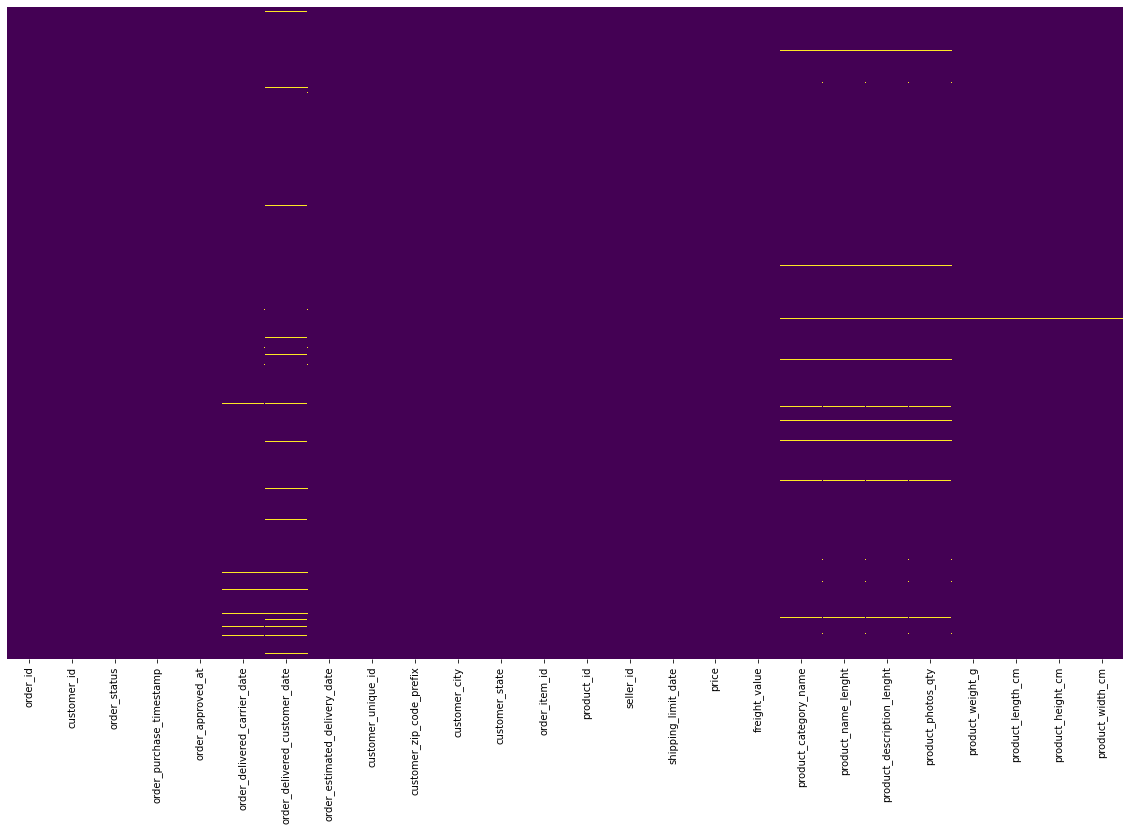

In [14]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [15]:
df = df.merge(product_category_name, on="product_category_name")
df

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
2       0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   
3       bfc39df4f36c3693ff3b63fcbea9e90a  53904ddbea91e1e92b2b3f1d09a7af86   
4       6ea2f835b4556291ffdc53fa0b3b95e8  c7340080e394356141681bd4c9b8fe31   
...                                  ...                               ...   
111018  0b82d0616f1ad8da15cf967b984b4004  986632b40c38f4240caf8608cb01d40d   
111019  2ef4a11b6e24fdfbb43b92cb5f95edff  ee1cfdc92e449920e25d3ca4ab4da4f6   
111020  2ef4a11b6e24fdfbb43b92cb5f95edff  ee1cfdc92e449920e25d3ca4ab4da4f6   
111021  2c4ada2e75c2ad41dd93cebb5df5f023  363d3a9b2ec5c5426608688ca033292d   
111022  bede3503afed051733eeb4a84d1adcc5  919570a26efbd068d6a0f66d5c5072a3   

       order_status order_purchase_timestamp    order_approved_at  \
0         delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1         delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
2         delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   
3         delivered      2017-10-23 23:26:46  2017-10-25 02:14:11   
4         delivered      2017-11-24 21:27:48  2017-11-25 00:21:09   
...             ...                      ...                  ...   
111018    delivered      2018-08-03 21:35:53  2018-08-04 04:25:14   
111019    delivered      2018-07-23 18:35:14  2018-07-24 10:31:25   
111020    delivered      2018-07-23 18:35:14  2018-07-24 10:31:25   
111021    delivered      2017-01-26 11:09:00  2017-01-26 11:22:17   
111022    delivered      2017-09-17 16:51:43  2017-09-19 04:05:52   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-10-04 19:55:00           2017-10-10 21:25:13   
1               2017-08-17 15:28:33           2017-08-18 14:44:43   
2               2017-08-04 17:35:43           2017-08-07 18:30:01   
3               2017-10-27 16:48:46           2017-11-07 18:04:59   
4               2017-12-13 21:14:05           2017-12-28 18:59:23   
...                             ...                           ...   
111018          2018-08-08 14:26:00           2018-08-09 21:42:08   
111019          2018-07-24 14:37:00           2018-07-27 14:04:10   
111020          2018-07-24 14:37:00           2018-07-27 14:04:10   
111021          2017-01-27 14:59:35           2017-02-14 16:24:01   
111022          2017-09-19 20:22:49           2017-09-28 18:14:35   

       order_estimated_delivery_date                customer_unique_id  \
0                         2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                         2017-08-28  3a51803cc0d012c3b5dc8b7528cb05f7   
2                         2017-08-15  ef0996a1a279c26e7ecbd737be23d235   
3                         2017-11-13  e781fdcc107d13d865fc7698711cc572   
4                         2017-12-21  3e4fd73f1e86b135b9b121d6abbe9597   
...                              ...                               ...   
111018                    2018-08-10  c887bc0b0717ee4a21d7d22137f12ee3   
111019                    2018-08-06  8d80e477643ec569b24592ce3d9dfc4c   
111020                    2018-08-06  8d80e477643ec569b24592ce3d9dfc4c   
111021                    2017-03-07  d8bee9ec375c3a0f9ef8ed7456a51dcd   
111022                    2017-10-11  141e824b8e0df709e3fcf6d982225a8e   

        customer_zip_code_prefix         customer_city customer_state  \
0                           3149             sao paulo             SP   
1                           3366             sao paulo             SP   
2                           2290             sao paulo             SP   
3                          88032         florianopolis             SC   
4                          19400  presidente venceslau             SP   
...                          ...                   ...            ...   
111018                     30575     

Got rid of some empty values from categories names 

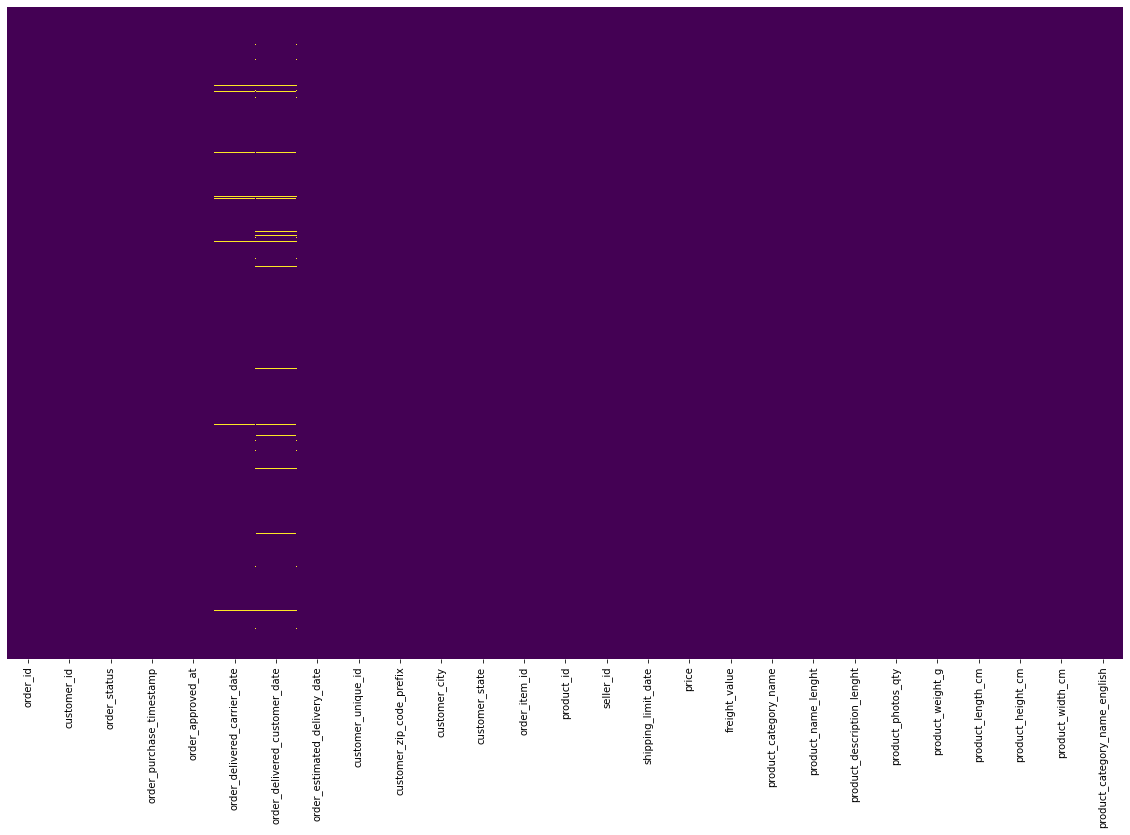

In [16]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

We still have some empty delivered_dates, it's 2% of all datarows




In [17]:
print(df['order_delivered_customer_date'].apply(type).value_counts())


<class 'str'>      108637
<class 'float'>      2386
Name: order_delivered_customer_date, dtype: int64


In [18]:
df['date'] = df['order_purchase_timestamp'].apply(lambda x:x.date())
# df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))


In [19]:
df.head(5)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
2  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   
3  bfc39df4f36c3693ff3b63fcbea9e90a  53904ddbea91e1e92b2b3f1d09a7af86   
4  6ea2f835b4556291ffdc53fa0b3b95e8  c7340080e394356141681bd4c9b8fe31   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
2    delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   
3    delivered      2017-10-23 23:26:46  2017-10-25 02:14:11   
4    delivered      2017-11-24 21:27:48  2017-11-25 00:21:09   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-08-17 15:28:33           2017-08-18 14:44:43   
2          2017-08-04 17:35:43           2017-08-07 18:30:01   
3          2017-10-27 16:48:46           2017-11-07 18:04:59   
4          2017-12-13 21:14:05           2017-12-28 18:59:23   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2017-08-28  3a51803cc0d012c3b5dc8b7528cb05f7   
2                    2017-08-15  ef0996a1a279c26e7ecbd737be23d235   
3                    2017-11-13  e781fdcc107d13d865fc7698711cc572   
4                    2017-12-21  3e4fd73f1e86b135b9b121d6abbe9597   

   customer_zip_code_prefix         customer_city customer_state  \
0                      3149             sao paulo             SP   
1                      3366             sao paulo             SP   
2                      2290             sao paulo             SP   
3                     88032         florianopolis             SC   
4                     19400  presidente venceslau             SP   

   order_item_id                        product_id  \
0              1  87285b34884572647811a353c7ac498a   
1              1  87285b34884572647811a353c7ac498a   
2              1  87285b34884572647811a353c7ac498a   
3              1  87285b34884572647811a353c7ac498a   
4              1  be021417a6acb56b9b50d3fd2714baa8   

                          seller_id shipping_limit_date   price  \
0  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99   
1  3504c0cb71d7fa48d967e0e4c94d59d9 2017-08-21 20:05:16   29.99   
2  3504c0cb71d7fa48d967e0e4c94d59d9 2017-08-08 18:37:31   29.99   
3  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-31 02:14:11   29.99   
4  f5f46307a4d15880ca14fab4ad9dfc9b 2017-11-30 00:21:09  339.00   

   freight_value  product_category_name  product_name_lenght  \
0           8.72  utilidades_domesticas                 40.0   
1           7.78  utilidades_domesticas                 40.0   
2           7.78  utilidades_domesticas                 40.0   
3          14.10  utilidades_domesticas                 40.0   
4          17.12  utilidades_domesticas                 48.0   

   product_description_lenght  product_photos_qty  product_weight_g  \
0                       268.0                 4.0             500.0   
1                       268.0                 4.0             500.0   
2                       268.0                 4.0             500.0   
3                       268.0                 4.0             500.0   
4                       664.0                 6.0           14300.0   

   product_length_cm  product_height_cm  product_width_cm  \
0               19.0                8.0              13.0   
1               19.0                8.0              13.0   
2               19.0                8.0              13.0   
3               19.0                8.0              13.0   
4               38.0               34.0              34.0   

  product_category_name_english        date  
0                    housewares  2017-10-

To build the dataset for this clustering we need:
- group by "customer_unique_id"
- get the result from today minus last date of purchase(recency)
- get the sum of price (monetary)
- get the count of "order_id" (frequency).

In [20]:
orders = df.groupby('customer_unique_id').agg({'order_id':'nunique', 'price':'sum', 'date':lambda x: (date.today() - x.max()).days}).reset_index()

In [21]:
orders = orders.rename(columns={'order_id':'frequency', 'price':'monetary', 'date':'recency'})
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94088 entries, 0 to 94087
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  94088 non-null  object 
 1   frequency           94088 non-null  int64  
 2   monetary            94088 non-null  float64
 3   recency             94088 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 2.9+ MB


In [22]:
from plotly.subplots import make_subplots


In [23]:
def format_title(title, subtitle=None):
    if not subtitle:
        return title
    subtitle = f'<span style="font-size: 10px;">{subtitle}</span>' # span is like a generic container
    return f'{title}<br>{subtitle}'


# it seems not the best choice to make subplots with plotly express (maybe only faceting or marginal charts)

fig = make_subplots(rows=1  , cols=3)

fig.add_trace(go.Histogram(x=orders['recency'], opacity=0.7, name="recency", marker_color='#05f77e'), row=1, col=1)
fig.add_trace(go.Histogram(x=orders['frequency'], opacity=0.9, name= 'frequency',marker_color='#13b3c2'), row=1, col=2)
fig.add_trace(go.Histogram(x=orders['monetary'], opacity=0.9, name='monetary', marker_color='#0206de'), row=1, col=3)

fig.update_xaxes(title_text="recency", row=1, col=1)
fig.update_xaxes(title_text="frequency", row=1, col=2)
fig.update_xaxes(title_text="monetary", row=1, col=3)


fig.update_layout(plot_bgcolor="white", title_text= format_title("RFM Histograms - Knowing the distributions", "Histogram shows how many observations fall into an interval"),title_x=0.5, showlegend=False)
fig.show()

## Clustering

### k-means

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [25]:
scaled_orders = StandardScaler().fit_transform(orders.drop(["customer_unique_id"], axis=1))
scaled_orders

array([[-0.16115292, -0.05788398, -0.82793148],
       [-0.16115292, -0.56822152, -0.80834452],
       [-0.16115292, -0.33787998,  1.95341566],
       ...,
       [-0.16115292, -0.2417894 ,  2.15581416],
       [-0.16115292, -0.12638875, -0.7756996 ],
       [-0.16115292, -0.39309759,  1.60737951]])

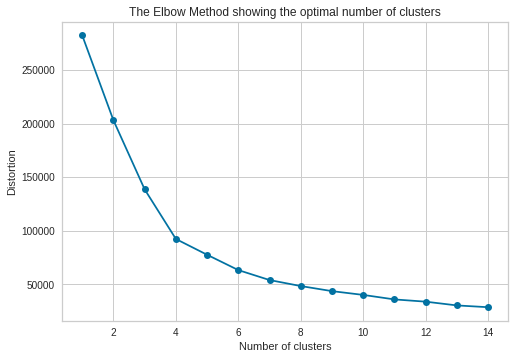

In [65]:
distortions=[]
for i in range(1, 15):
    kmodel=KMeans(n_clusters=i, n_init=5, random_state=10)
    kmodel.fit(scaled_orders)
    distortions.append(kmodel.inertia_) # KMeans inertia = Sum of Squares Errors (SSE)
    
plt.plot(range(1,15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()

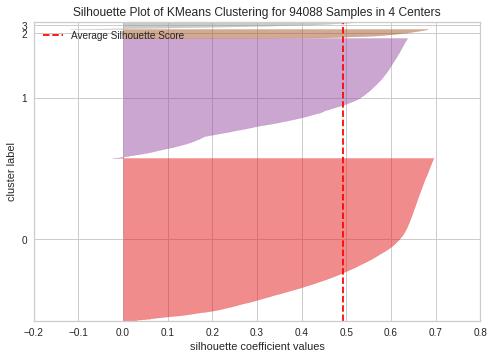

In [26]:
vis = SilhouetteVisualizer(KMeans(n_clusters=4, n_init=5, random_state=10))
vis.fit(scaled_orders)
vis.show()

In [27]:
kmodel = KMeans(n_clusters=4, n_init=5, random_state=10)
kmodel.fit(scaled_orders)
silhouette_score(scaled_orders, kmodel.labels_)

0.49163114213581904

In [35]:
kmodel=KMeans(n_clusters=4,n_init=5,random_state=1)
orders["cluster_kmeans"] = kmodel.fit_predict(scaled_orders)

fig= px.scatter_3d(orders, x='frequency', y='monetary', z='recency', color='cluster_kmeans',opacity=0.5)
fig.update_traces(marker_size = 3)
fig.show()

In [36]:
orders_table=orders.groupby('cluster_kmeans').agg(mean_frequency=pd.NamedAgg('frequency', 'mean'),
                                           mean_recency=pd.NamedAgg('recency', 'mean'),
                                           mean_monetary=pd.NamedAgg('monetary', 'mean'),
                                           cluster_size=pd.NamedAgg('cluster_kmeans','count')).reset_index()
orders_table=orders_table.round({"mean_frequency":1, "mean_recency":0, "mean_monetary":0})
orders_table=orders_table.astype({'mean_recency':'int', 'mean_monetary':'int'})
orders_table

cluster_kmeans  mean_frequency  mean_recency  mean_monetary  cluster_size
0               0             1.0          1718            113         51256
1               1             2.1          1810            244          2821
2               2             1.0          1978            115         37767
3               3             1.0          1828           1143          2244

### dbscan

In [33]:
dmodel = DBSCAN(eps=0.2, min_samples=20, metric='euclidean')
orders["cluster_dbscan"] = dmodel.fit_predict(scaled_orders)

fig = px.scatter_3d(orders, x='frequency', y='monetary', z='recency', color='cluster_dbscan',opacity=0.5)
fig.update_traces(marker_size = 3)
fig.show()

#Analysis Full

Adding the remaining information

In [96]:
data = df.merge(olist_order_payments, on = 'order_id') \
                .merge(olist_order_reviews, on = 'order_id') \
                .merge(olist_sellers, on = 'seller_id')
data

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3       128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4       0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   
...                                  ...                               ...   
115604  edcf1e1eeb52381be9388c90152be52d  ce2172509c4149d65212484eb761bc37   
115605  2c12150c742ae2fa48bc703964c16c5f  ab0cf72dfe0538a63a57d6905ccb7b57   
115606  9f7ba492c273ffac8f90a623b8eadd3b  c61336d6c835632048f973d2f2db598d   
115607  2ef4a11b6e24fdfbb43b92cb5f95edff  ee1cfdc92e449920e25d3ca4ab4da4f6   
115608  2ef4a11b6e24fdfbb43b92cb5f95edff  ee1cfdc92e449920e25d3ca4ab4da4f6   

       order_status order_purchase_timestamp    order_approved_at  \
0         delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1         delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2         delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3         delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
4         delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   
...             ...                      ...                  ...   
115604    delivered      2018-08-21 11:29:05  2018-08-21 11:50:47   
115605    delivered      2018-07-28 17:55:27  2018-07-29 18:30:31   
115606    delivered      2018-08-23 12:31:37  2018-08-24 03:24:24   
115607    delivered      2018-07-23 18:35:14  2018-07-24 10:31:25   
115608    delivered      2018-07-23 18:35:14  2018-07-24 10:31:25   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-10-04 19:55:00           2017-10-10 21:25:13   
1               2017-10-04 19:55:00           2017-10-10 21:25:13   
2               2017-10-04 19:55:00           2017-10-10 21:25:13   
3               2017-08-17 15:28:33           2017-08-18 14:44:43   
4               2017-08-04 17:35:43           2017-08-07 18:30:01   
...                             ...                           ...   
115604          2018-08-21 15:37:00           2018-08-24 13:06:25   
115605          2018-07-30 14:54:00           2018-08-03 17:46:46   
115606          2018-08-24 15:14:00           2018-08-28 02:06:35   
115607          2018-07-24 14:37:00           2018-07-27 14:04:10   
115608          2018-07-24 14:37:00           2018-07-27 14:04:10   

       order_estimated_delivery_date                customer_unique_id  \
0                         2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                         2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
2                         2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
3                         2017-08-28  3a51803cc0d012c3b5dc8b7528cb05f7   
4                         2017-08-15  ef0996a1a279c26e7ecbd737be23d235   
...                              ...                               ...   
115604                    2018-09-06  c5da6424f1f5decedef8672a1a0103e1   
115605                    2018-08-16  8c3c961a52bb5a0ffbce1d4e6d25cd67   
115606                    2018-09-03  428f4721a509be8c52de6ec2900ba918   
115607                    2018-08-06  8d80e477643ec569b24592ce3d9dfc4c   
115608                    2018-08-06  8d80e477643ec569b24592ce3d9dfc4c   

        customer_zip_code_prefix   customer_city customer_state  \
0                           3149       sao paulo             SP   
1                           3149       sao paulo             SP   
2                           3149       sao paulo             SP   
3                           3366       sao paulo             SP   
4                           2290       sao paulo             SP   
...                          ...             ...            ...   
115604                     88350         brusque             SC   
115605      

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115609 non-null  object        
 1   customer_id                    115609 non-null  object        
 2   order_status                   115609 non-null  object        
 3   order_purchase_timestamp       115609 non-null  datetime64[ns]
 4   order_approved_at              115595 non-null  object        
 5   order_delivered_carrier_date   114414 non-null  object        
 6   order_delivered_customer_date  113209 non-null  object        
 7   order_estimated_delivery_date  115609 non-null  datetime64[ns]
 8   customer_unique_id             115609 non-null  object        
 9   customer_zip_code_prefix       115609 non-null  int64         
 10  customer_city                  115609 non-null  object        
 11  

Rename names with errors

In [97]:
data.rename(columns = {'product_name_lenght':'product_name_length', 
                       'product_description_lenght':'product_description_length'}, inplace = True)

In [98]:
for feature in ['customer_zip_code_prefix', 'seller_zip_code_prefix']:
    data[feature] = data[feature].astype('object')

for feature in ['order_approved_at', 'order_delivered_carrier_date', 
                'order_delivered_customer_date',
                'review_creation_date', 'review_answer_timestamp']:
    data[feature] = pd.to_datetime(data[feature], errors = 'raise', utc = False)

In [41]:
data.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_unique_id                       object
customer_zip_code_prefix                 object
customer_city                            object
customer_state                           object
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           float64
product_category_name                    object
product_name_length                     float64
product_description_length              

In [99]:
total = data.isnull().sum().sort_values(ascending = False)          
percent = (data.isnull().sum()*100/data.isnull().count()).sort_values(ascending = False)   
missing_data = pd.concat([total, percent], axis = 1, keys = ['total', 'percentage of Missing Values'])    
missing_data

total  percentage of Missing Values
review_comment_title           101808                     88.062348
review_comment_message          66703                     57.697065
order_delivered_customer_date    2400                      2.075963
order_delivered_carrier_date     1195                      1.033657
order_approved_at                  14                      0.012110
product_length_cm                   1                      0.000865
product_height_cm                   1                      0.000865
product_width_cm                    1                      0.000865
product_weight_g                    1                      0.000865
payment_installments                0                      0.000000
product_category_name_english       0                      0.000000
date                                0                      0.000000
payment_sequential                  0                      0.000000
payment_type                        0                      0.000000
order_id                            0                      0.000000
payment_value                       0                      0.000000
review_id                           0                      0.000000
review_creation_date                0                      0.000000
review_answer_timestamp             0                      0.000000
seller_zip_code_prefix              0                      0.000000
seller_city                         0                      0.000000
review_score                        0                      0.000000
product_description_length          0                      0.000000
product_photos_qty                  0                      0.000000
customer_id                         0                      0.000000
order_status                        0                      0.000000
order_purchase_timestamp            0                      0.000000
order_estimated_delivery_date       0                      0.000000
customer_unique_id                  0                      0.000000
customer_zip_code_prefix            0                      0.000000
customer_city                       0                      0.000000
customer_state                      0                      0.000000
order_item_id                       0                      0.000000
product_id                          0                      0.000000
seller_id                           0                      0.000000
shipping_limit_date                 0                      0.000000
price                               0                      0.000000
freight_value                       0                      0.000000
product_category_name               0                      0.000000
product_name_length                 0                      0.000000
seller_state                        0                      0.000000

In [100]:
data.drop(['review_comment_title', 'review_comment_message'], axis = 1, inplace = True)
data.dropna(axis = 0, inplace = True)



In [101]:
data.shape

(113193, 39)

In [45]:
data.describe(datetime_is_numeric = True).T

count                           mean  \
order_purchase_timestamp         113193  2018-01-01 07:46:22.707817728   
order_approved_at                113193  2018-01-01 18:12:25.359050496   
order_delivered_carrier_date     113193  2018-01-04 14:19:54.360985088   
order_delivered_customer_date    113193  2018-01-13 18:22:26.739418624   
order_estimated_delivery_date    113193  2018-01-25 03:50:01.955951360   
order_item_id                  113193.0                       1.195065   
shipping_limit_date              113193  2018-01-07 22:21:08.998047232   
price                          113193.0                      119.84665   
freight_value                  113193.0                      20.002595   
product_name_length            113193.0                      48.802894   
product_description_length     113193.0                     784.727183   
product_photos_qty             113193.0                       2.206833   
product_weight_g               113193.0                    2106.236075   
product_length_cm              113193.0                      30.278091   
product_height_cm              113193.0                      16.597422   
product_width_cm               113193.0                      23.099679   
payment_sequential             113193.0                       1.090818   
payment_installments           113193.0                        2.94368   
payment_value                  113193.0                     171.557922   
review_score                   113193.0                       4.082505   
review_creation_date             113193  2018-01-13 13:43:38.843921152   
review_answer_timestamp          113193  2018-01-16 17:26:39.174851584   

                                               min                  25%  \
order_purchase_timestamp       2016-10-03 09:44:50  2017-09-13 14:12:25   
order_approved_at              2016-10-04 09:43:32  2017-09-13 22:05:44   
order_delivered_carrier_date   2016-10-08 10:34:01  2017-09-15 20:07:55   
order_delivered_customer_date  2016-10-11 13:46:32  2017-09-25 18:34:40   
order_estimated_delivery_date  2016-10-27 00:00:00  2017-10-04 00:00:00   
order_item_id                                  1.0                  1.0   
shipping_limit_date            2016-10-08 10:34:01  2017-09-20 13:24:55   
price                                         0.85                 39.9   
freight_value                                  0.0                13.08   
product_name_length                            5.0                 42.0   
product_description_length                     4.0                346.0   
product_photos_qty                             1.0                  1.0   
product_weight_g                               0.0                300.0   
product_length_cm                              7.0                 18.0   
product_height_cm                              2.0                  8.0   
product_width_cm                               6.0                 15.0   
payment_sequential                             1.0                  1.0   
payment_installments                           0.0                  1.0   
payment_value                                  0.0                60.85   
review_score                                   1.0                  4.0   
review_creation_date           2016-10-15 00:00:00  2017-09-26 00:00:00   
review_answer_timestamp        2016-10-16 03:20:17  2017-09-28 01:45:41   

                                               50%                  75%  \
order_purchase_timestamp       2018-01-20 09:22:45  2018-05-05 13:57:15   
order_approved_at              2018-01-20 16:00:33  2018-05-05 19:50:47   
order_delivered_carrier_date   2018-01-24 00:23:35  2018-05-08 14:07:00   
order_delivered_customer_date  2018-02-02 02:15:19  2018-05-15 20:02:55   
order_estimated_delivery_date  2018-02-16 00:00:00  2018-05-28 00:00:00   
order_item_id                                  1.0                  1.0   
shipping_limit_date            2018-01-26 14:14:20  2018-05-10 19:15:24   
price

In [46]:
data.describe(include = 'object').T

count unique  \
order_id                       113193  94471   
customer_id                    113193  94471   
order_status                   113193      2   
customer_unique_id             113193  91465   
customer_zip_code_prefix       113193  14825   
customer_city                  113193   4071   
customer_state                 113193     27   
product_id                     113193  31474   
seller_id                      113193   2907   
product_category_name          113193     71   
product_category_name_english  113193     71   
date                           113193    611   
payment_type                   113193      4   
review_id                      113193  94295   
seller_zip_code_prefix         113193   2133   
seller_city                    113193    587   
seller_state                   113193     22   

                                                            top    freq  
order_id                       895ab968e7bb0d5659d16cd74cd1650c      63  
customer_id                    270c23a11d024a44c896d1894b261a83      63  
order_status                                          delivered  113186  
customer_unique_id             9a736b248f67d166d2fbb006bcb877c3      75  
customer_zip_code_prefix                                  24220     150  
customer_city                                         sao paulo   17871  
customer_state                                               SP   47812  
product_id                     aca2eb7d00ea1a7b8ebd4e68314663af     526  
seller_id                      4a3ca9315b744ce9f8e9374361493884    2093  
product_category_name                           cama_mesa_banho   11684  
product_category_name_english                    bed_bath_table   11684  
date                                                 2017-11-24    1379  
payment_type                                        credit_card   83534  
review_id                      eef5dbca8d37dfce6db7d7b16dd0525e      63  
seller_zip_code_prefix                                    14940    8097  
seller_city                                           sao paulo   28205  
seller_state                                                 SP   80728

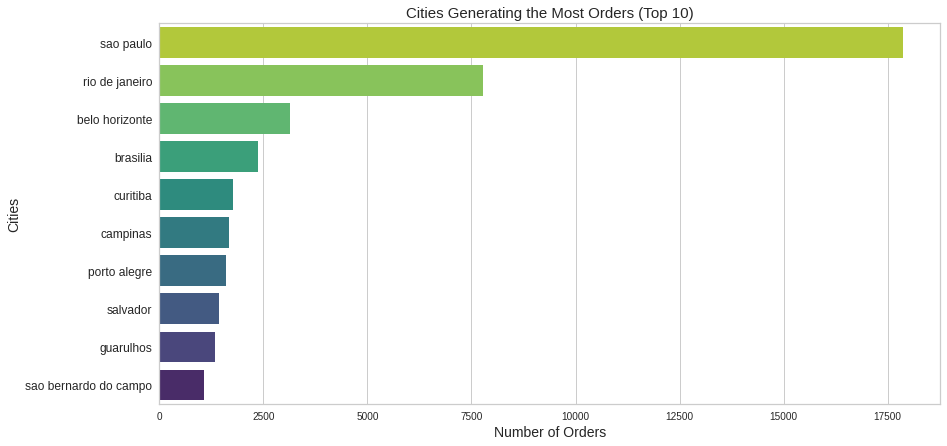

In [47]:
top_orders_cities = data.groupby("customer_city")["order_id"].count().reset_index().sort_values("order_id", ascending = False)
plt.figure(figsize = (14, 7))
sns.barplot(x = "order_id", y = "customer_city", data = top_orders_cities[:10], palette = 'viridis_r')
plt.xlabel("Number of Orders", fontsize = 14)
plt.ylabel("Cities", fontsize = 14)
plt.yticks(fontsize = 12)
plt.title("Cities Generating the Most Orders (Top 10)", fontsize = 15)
plt.show()

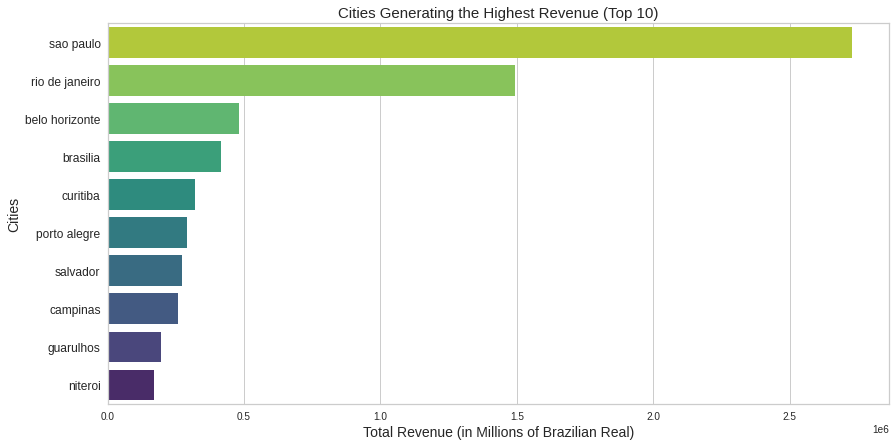

In [48]:
top_revenue_cities = data.groupby("customer_city")["payment_value"].sum().reset_index().sort_values("payment_value", ascending = False)
plt.figure(figsize = (14, 7))
sns.barplot(x = "payment_value", y = "customer_city", data = top_revenue_cities[:10], palette = 'viridis_r')
plt.xlabel("Total Revenue (in Millions of Brazilian Real)", fontsize = 14)
plt.ylabel("Cities", fontsize = 14)
plt.yticks(fontsize = 12)
plt.title("Cities Generating the Highest Revenue (Top 10)", fontsize = 15)
plt.show()

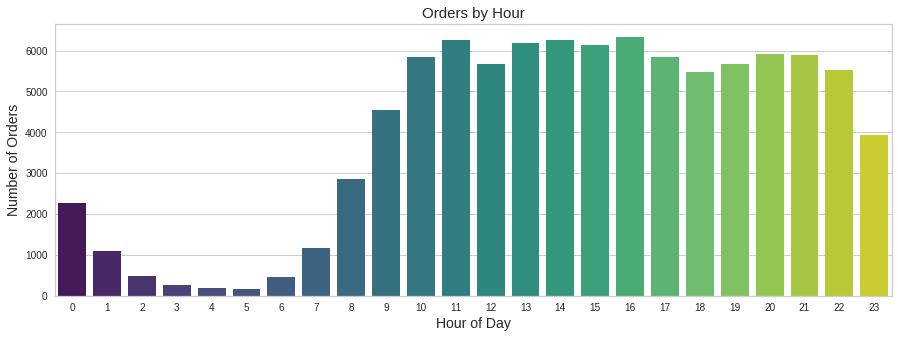

In [49]:
orders_byHour = data.groupby(data.order_purchase_timestamp.dt.hour)['order_id'].nunique().reset_index()
plt.figure(figsize = (15, 5))
sns.barplot(x = 'order_purchase_timestamp', y = 'order_id', data = orders_byHour, palette = 'viridis')
plt.xlabel("Hour of Day", fontsize = 14)
plt.ylabel("Number of Orders", fontsize = 14)
plt.title("Orders by Hour", fontsize = 15)
plt.show()

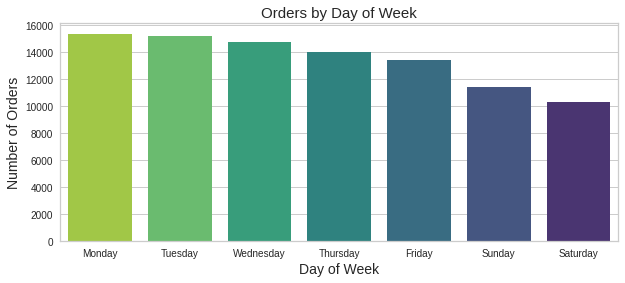

In [50]:
orders_byDays = data.groupby(data.order_purchase_timestamp.dt.day_name())['order_id'].nunique().reset_index().sort_values('order_id', ascending = False)
plt.figure(figsize = (10, 4))
sns.barplot(x = 'order_purchase_timestamp', y = 'order_id', data = orders_byDays, palette = 'viridis_r')
plt.xlabel("Day of Week", fontsize = 14)
plt.ylabel("Number of Orders", fontsize = 14)
plt.title("Orders by Day of Week", fontsize = 15)
plt.show()

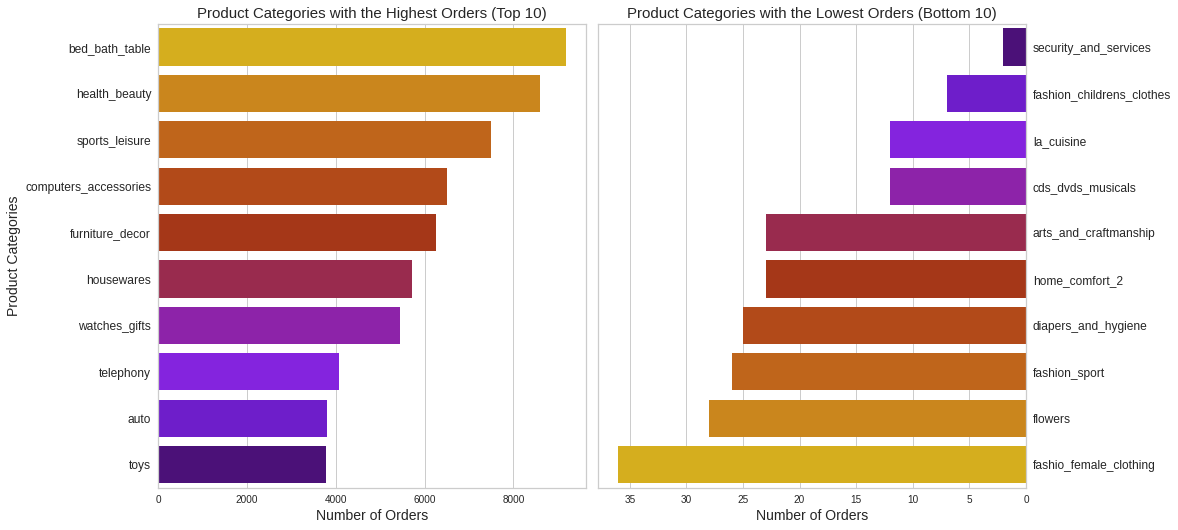

In [52]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16.5, 7.5))

prodCat_TopOrders = data.groupby(data['product_category_name_english'])['order_id'].nunique().reset_index().sort_values('order_id', ascending = False)
sns.barplot(x = 'order_id', y = 'product_category_name_english', data = prodCat_TopOrders[:10], palette = 'gnuplot_r', ax = ax[0])
ax[0].set_xlabel("Number of Orders", fontsize = 14)
ax[0].set_ylabel("Product Categories", fontsize = 14)
ax[0].tick_params(axis = 'y', labelsize = 12)
ax[0].set_title("Product Categories with the Highest Orders (Top 10)", fontsize = 15)

prodCat_BotOrders = data.groupby(data['product_category_name_english'])['order_id'].nunique().reset_index().sort_values('order_id', ascending = True)
sns.barplot(x = 'order_id', y = 'product_category_name_english', data = prodCat_BotOrders[:10], palette = 'gnuplot', ax = ax[1])
ax[1].set_xlabel("Number of Orders", fontsize = 14)
ax[1].set_ylabel("")
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].tick_params(axis = 'y', labelsize = 12)
ax[1].set_title("Product Categories with the Lowest Orders (Bottom 10)", fontsize = 15)

plt.tight_layout(pad = 1)
plt.show()

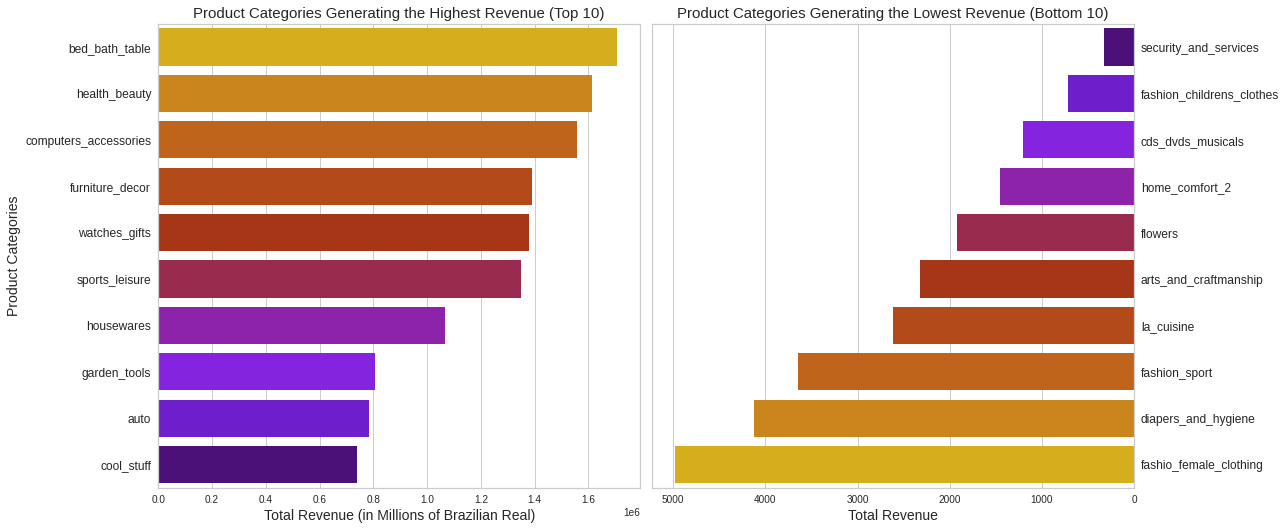

In [53]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 7.5))

prodCat_TopRevenue = data.groupby(data['product_category_name_english'])['payment_value'].sum().reset_index().sort_values('payment_value', ascending = False)
sns.barplot(x = 'payment_value', y = 'product_category_name_english', data = prodCat_TopRevenue[:10], palette = 'gnuplot_r', ax = ax[0])
ax[0].set_xlabel("Total Revenue (in Millions of Brazilian Real)", fontsize = 14)
ax[0].set_ylabel("Product Categories", fontsize = 14)
ax[0].tick_params(axis = 'y', labelsize = 12)
ax[0].set_title("Product Categories Generating the Highest Revenue (Top 10)", fontsize = 15)

prodCat_BotRevenue = data.groupby(data['product_category_name_english'])['payment_value'].sum().reset_index().sort_values('payment_value', ascending = True)
sns.barplot(x = 'payment_value', y = 'product_category_name_english', data = prodCat_BotRevenue[:10], palette = 'gnuplot', ax = ax[1])
ax[1].set_xlabel("Total Revenue", fontsize = 14)
ax[1].set_ylabel("")
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].tick_params(axis = 'y', labelsize = 12)
ax[1].set_title("Product Categories Generating the Lowest Revenue (Bottom 10)", fontsize = 15)

plt.tight_layout(pad = 1)
plt.show()

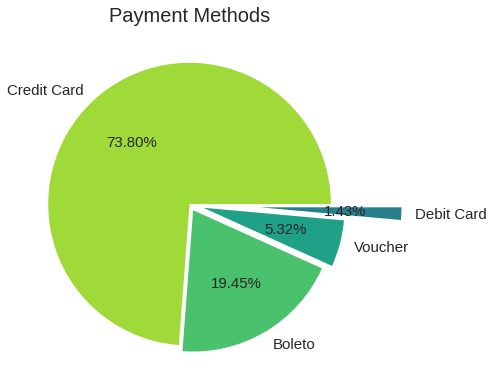

In [54]:
plt.figure(figsize = (10, 6.5))
payment_type_counts = data.payment_type.value_counts()
plt.pie(x = payment_type_counts.to_list(), labels = ['Credit Card', 'Boleto', 'Voucher', 'Debit Card'], 
        autopct = '%1.2f%%', explode = (0, 0.05, 0.1, 0.5), colors = sns.color_palette('viridis_r'), 
        textprops = {'fontsize': 15})
plt.title("Payment Methods", fontsize = 20)
plt.show()

In [102]:
deliveryTime = (data["order_delivered_customer_date"] - data["order_purchase_timestamp"])
deliveryTime_Seconds = deliveryTime.apply(lambda x: x.total_seconds())
data['deliveryTime_Days'] = round(deliveryTime_Seconds/86400, 2)

#Summarizing the delivery time:
data['deliveryTime_Days'].describe()

count    113193.000000
mean         12.441694
std           9.355858
min           0.530000
25%           6.740000
50%          10.190000
75%          15.500000
max         208.350000
Name: deliveryTime_Days, dtype: float64

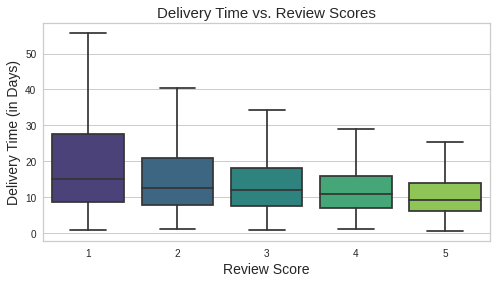

In [57]:
plt.figure(figsize = (8, 4))
sns.boxplot(x = "review_score", y = "deliveryTime_Days", data = data, showfliers = False, palette = 'viridis')
plt.xlabel("Review Score", fontsize = 14)
plt.ylabel("Delivery Time (in Days)", fontsize = 14)
plt.title("Delivery Time vs. Review Scores", fontsize = 15)
plt.show()

There's a slight correlation between delivery times and review scores. The longer it takes for an order to be delivered, the more likely it is to receive a low review score.

### RFM

In [58]:
df_recency = data.groupby(by = 'customer_unique_id', as_index = False)['order_purchase_timestamp'].max()
df_recency.rename(columns = {"order_purchase_timestamp": "LastPurchaseDate"}, inplace = True)
df_recency["LastPurchaseDate"] = df_recency["LastPurchaseDate"].dt.date
recent_date = data['order_purchase_timestamp'].dt.date.max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
frequency_df = data.groupby(["customer_unique_id"]).agg({"order_id": "nunique"}).reset_index()
frequency_df.rename(columns = {"order_id": "Frequency"}, inplace = True)
monetary_df = data.groupby('customer_unique_id', as_index = False)['payment_value'].sum()
monetary_df.rename(columns = {"payment_value": "Monetary"}, inplace = True)
rfm = df_recency.merge(frequency_df, on = 'customer_unique_id') \
                .merge(monetary_df, on = 'customer_unique_id')
rfm.drop('LastPurchaseDate', axis = 1, inplace = True)

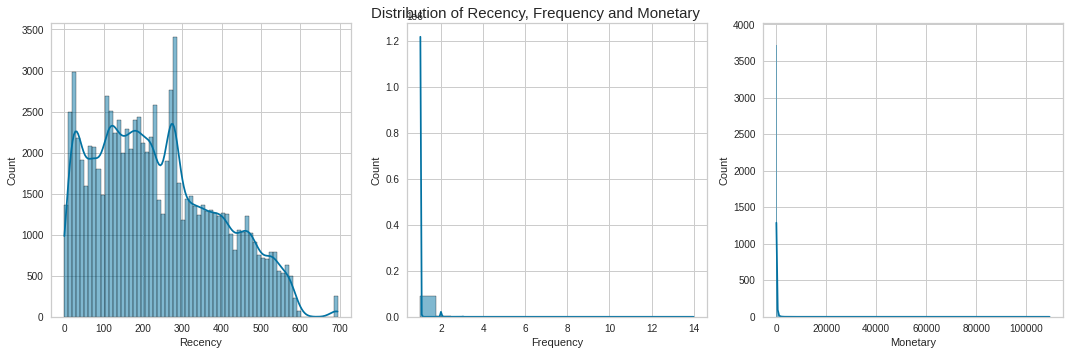

In [60]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
sns.histplot(rfm['Recency'], kde = True, ax = ax[0])
sns.histplot(rfm['Frequency'], kde = True, ax = ax[1])
sns.histplot(rfm['Monetary'], kde = True, ax = ax[2])
plt.suptitle('Distribution of Recency, Frequency and Monetary', fontsize = 15)
plt.tight_layout(pad = 1)
plt.show()

Not very even dict for Freq and Monet

In [61]:
rfm_transformed = rfm.copy()
for feature in rfm.columns[2:]:
    rfm_transformed[feature] = rfm_transformed[feature].apply(lambda x: np.power(x, (1/10))) 

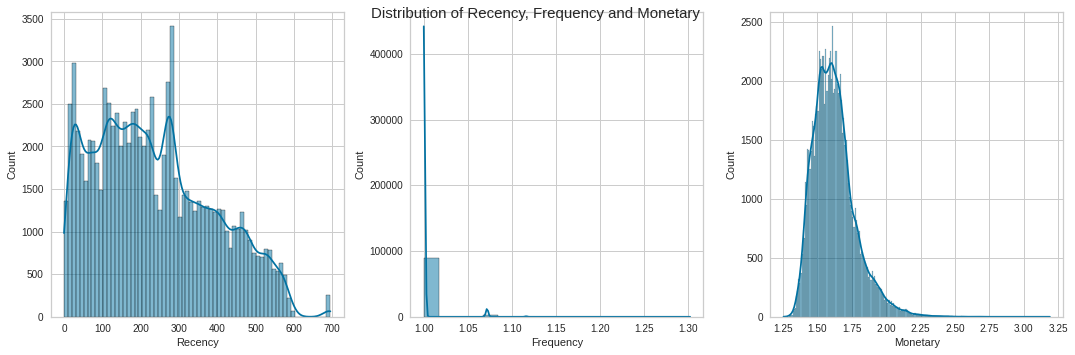

In [62]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
sns.histplot(rfm_transformed['Recency'], kde = True, ax = ax[0])
sns.histplot(rfm_transformed['Frequency'], kde = True, ax = ax[1])
sns.histplot(rfm_transformed['Monetary'], kde = True, ax = ax[2])
plt.suptitle('Distribution of Recency, Frequency and Monetary', fontsize = 15)
plt.tight_layout(pad = 1)
plt.show()

In [63]:
scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfm.drop('customer_unique_id', axis = 1))
scaled_rfm_df = pd.DataFrame(scaled_rfm, columns = rfm.columns[1:])

### K-means

In [70]:
n_clusters = [3, 4, 5, 6, 7, 8]
silhouette_scores = []

for k in n_clusters:
    initialized_clusters = KMeans(n_clusters = k, random_state = 42)
    data_fitted_clusters = initialized_clusters.fit_predict(scaled_rfm_df)
    silhoette_score = silhouette_score(scaled_rfm_df, data_fitted_clusters, random_state = 42)
    print(k, silhoette_score)
    silhouette_scores.append(silhoette_score)

3 0.5268306658917041
4 0.5285527208304655
5 0.5325711712103828
6 0.47887874559479576
7 0.4940918751132654
8 0.49657937911869365


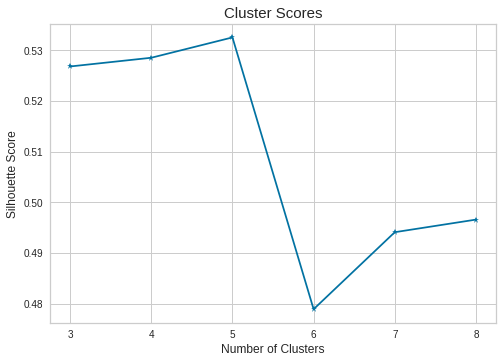

In [71]:
plt.plot(n_clusters, silhouette_scores, color = 'b', marker = '*')
plt.title('Cluster Scores', fontsize = 15)
plt.xlabel('Number of Clusters', fontsize = 12)
plt.ylabel('Silhouette Score', fontsize = 12)
plt.show()

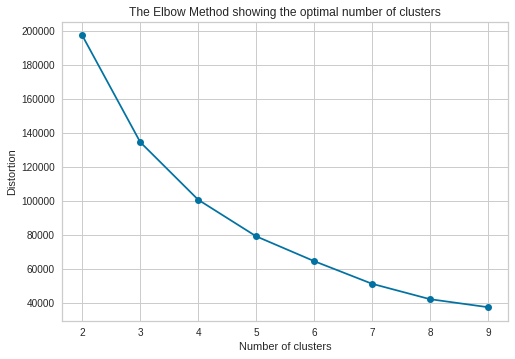

In [75]:
distortions=[]
for i in range(2, 10):
    kmodel=KMeans(n_clusters=i, n_init=5, random_state=42)
    kmodel.fit(scaled_rfm_df)
    distortions.append(kmodel.inertia_) # KMeans inertia = Sum of Squares Errors (SSE)
    
plt.plot(range(2,10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()

In [86]:
final_model = KMeans(n_clusters = 4, random_state = 42)
final_model.fit(scaled_rfm_df)

KMeans(n_clusters=4, random_state=42)

In [87]:
data_output = rfm.copy()
data_output['Cluster'] = final_model.labels_
data_output.sample(5)

customer_unique_id  Recency  Frequency  Monetary  Cluster
31713  5876dd2eba90a1f7ce5d0548c46e281a      128          1     96.43        0
41263  732d307839b02bc2d3a4c26b515ea2b9      179          3    219.02        2
90057  fc06bc49c99d65a0828a32b606dcd059      236          1     89.88        0
88252  f6d3a127cdf442b5aae64b8af6dc8645       39          1     93.28        0
85863  f011ec6a7ffc9c940ebf00a55e0e1dc5       66          1    111.23        0

###Cluster analysis

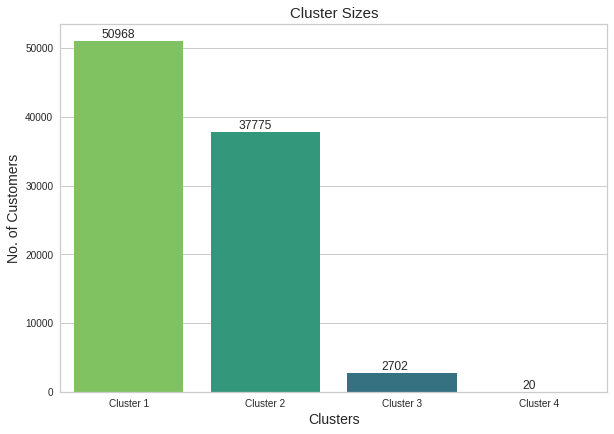

In [88]:
sns.countplot(data = data_output, x = 'Cluster', palette = 'viridis_r')
plt.title('Cluster Sizes', fontsize = 15)
plt.xlabel('Clusters', fontsize = 14)
plt.ylabel('No. of Customers', fontsize = 14)
plt.xticks([0, 1, 2, 3], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], rotation = 0)
plt.text(x = 0 - 0.2, y = data_output.Cluster.value_counts()[0] + 500, s = data_output.Cluster.value_counts()[0])
plt.text(x = 1 - 0.2, y = data_output.Cluster.value_counts()[1] + 500, s = data_output.Cluster.value_counts()[1])
plt.text(x = 2 - 0.15, y = data_output.Cluster.value_counts()[2] + 500, s = data_output.Cluster.value_counts()[2])
plt.text(x = 3 - 0.12, y = data_output.Cluster.value_counts()[3] + 500, s = data_output.Cluster.value_counts()[3])
# plt.text(x = 4 - 0.05, y = data_output.Cluster.value_counts()[4] + 500, s = data_output.Cluster.value_counts()[4])
plt.tight_layout(pad = -1)
plt.show()

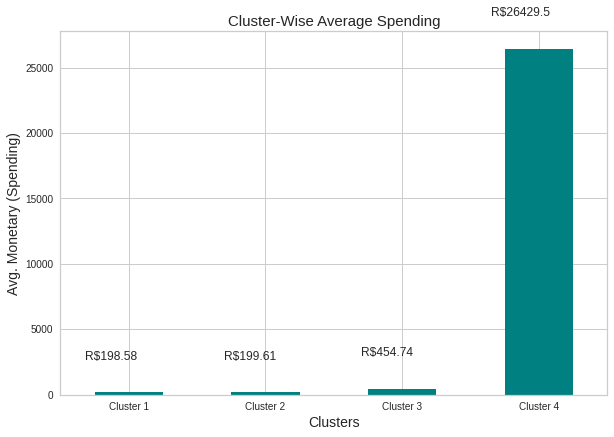

In [89]:
monetary_averages = pd.Series(data_output.groupby(by = 'Cluster')['Monetary'].mean())
monetary_averages.plot(kind = 'bar', color = 'teal')
plt.title('Cluster-Wise Average Spending', fontsize = 15)
plt.xlabel('Clusters', fontsize = 14)
plt.ylabel('Avg. Monetary (Spending)', fontsize = 14)
plt.xticks([0, 1, 2, 3], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], rotation = 0)
plt.text(x = 0 - 0.32, y = monetary_averages[0] + 2500, s = "R${}".format(monetary_averages[0].round(2)))
plt.text(x = 1 - 0.30, y = monetary_averages[1] + 2500, s = "R${}".format(monetary_averages[1].round(2)))
plt.text(x = 2 - 0.30, y = monetary_averages[2] + 2500, s = "R${}".format(monetary_averages[2].round(2)))
plt.text(x = 3 - 0.35, y = monetary_averages[3] + 2500, s = "R${}".format(monetary_averages[3].round(2)))
# plt.text(x = 4 - 0.40, y = monetary_averages[4] + 1500, s = "R${}".format(monetary_averages[4].round(2)))
plt.tight_layout(pad = -1)
plt.show()

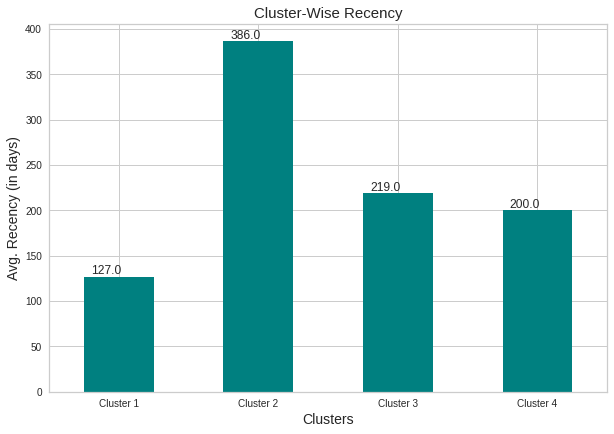

In [90]:
recency_averages = pd.Series(data_output.groupby(by = 'Cluster')['Recency'].mean())
recency_averages.plot(kind = 'bar', color = 'teal')
plt.title('Cluster-Wise Recency', fontsize = 15)
plt.xlabel('Clusters', fontsize = 14)
plt.ylabel('Avg. Recency (in days)', fontsize = 14)
plt.xticks([0, 1, 2, 3], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], rotation = 0)
plt.text(x = 0 - 0.2, y = recency_averages[0] + 3, s = "{}".format(recency_averages[0].round(0)))
plt.text(x = 1 - 0.2, y = recency_averages[1] + 3, s = "{}".format(recency_averages[1].round(0)))
plt.text(x = 2 - 0.2, y = recency_averages[2] + 3, s = "{}".format(recency_averages[2].round(0)))
plt.text(x = 3 - 0.2, y = recency_averages[3] + 3, s = "{}".format(recency_averages[3].round(0)))
# plt.text(x = 4 - 0.2, y = recency_averages[4] + 3, s = "{}".format(recency_averages[4].round(0)))
plt.tight_layout(pad = -1)
plt.show()

In [91]:
rfm_agg = data_output.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean', 
    'Monetary': 'mean',
    'Cluster': 'count'
}).round(1)

rfm_agg.rename(columns = {"Recency": "Avg. Recency",
                          "Frequency": "Avg. Frequency",
                          "Monetary": "Avg. Monetary",
                          "Cluster": "Customer Count"
                         }, inplace = True)

rfm_agg

Avg. Recency  Avg. Frequency  Avg. Monetary  Customer Count
Cluster                                                             
0               126.7             1.0          198.6           50968
1               386.2             1.0          199.6           37775
2               219.2             2.1          454.7            2702
3               200.1             1.3        26429.5              20

##Adding marketing info


In [107]:
data_m = data.copy()

In [111]:
olist_closed_deals = pd.read_csv(raw_path + 'olist_closed_deals_dataset.csv')
olist_marketing = pd.read_csv(raw_path + 'olist_marketing_qualified_leads_dataset.csv',
                  parse_dates=['first_contact_date'])

In [112]:
mf = olist_marketing.merge(olist_closed_deals, on='mql_id', how='left')
mf

mql_id first_contact_date  \
0     dac32acd4db4c29c230538b72f8dd87d         2018-02-01   
1     8c18d1de7f67e60dbd64e3c07d7e9d5d         2017-10-20   
2     b4bc852d233dfefc5131f593b538befa         2018-03-22   
3     6be030b81c75970747525b843c1ef4f8         2018-01-22   
4     5420aad7fec3549a85876ba1c529bd84         2018-02-21   
...                                ...                ...   
7995  feaba3ffcd2ff97501696c7f9a42f41c         2018-05-22   
7996  a79cb53cd009ab92e0143b92baa2407b         2018-03-27   
7997  68f049a23ab109c6a0f6989bb9a02994         2017-08-27   
7998  4f8c96e2509b984329044c6682c88ee9         2017-10-06   
7999  8a6492305a5fbcdcdd1a7f5a90764c07         2018-01-11   

                       landing_page_id          origin  \
0     88740e65d5d6b056e0cda098e1ea6313          social   
1     007f9098284a86ee80ddeb25d53e0af8     paid_search   
2     a7982125ff7aa3b2054c6e44f9d28522  organic_search   
3     d45d558f0daeecf3cccdffe3c59684aa           email   
4     b48ec5f3b04e9068441002a19df93c6c  organic_search   
...                                ...             ...   
7995  e42a14209c69c3e9cc6b042620465f12     paid_search   
7996  c494978688ccf66ad9fad3d6a3338c22     paid_search   
7997  b48ec5f3b04e9068441002a19df93c6c  organic_search   
7998  a56671a54260a44923d32c2f08fad39c  organic_search   
7999  b76ef37428e6799c421989521c0e5077  direct_traffic   

                             seller_id                            sdr_id  \
0                                  NaN                               NaN   
1                                  NaN                               NaN   
2                                  NaN                               NaN   
3                                  NaN                               NaN   
4     2c43fb513632d29b3b58df74816f1b06  a8387c01a09e99ce014107505b92388c   
...                                ...                               ...   
7995                               NaN                               NaN   
7996                               NaN                               NaN   
7997                               NaN                               NaN   
7998                               NaN                               NaN   
7999  1bba9c94eb5c4e82fba9f7286fe81025  56bf83c4bb35763a51c2baab501b4c67   

                                 sr_id             won_date  \
0                                  NaN                  NaN   
1                                  NaN                  NaN   
2                                  NaN                  NaN   
3                                  NaN                  NaN   
4     4ef15afb4b2723d8f3d81e51ec7afefe  2018-02-26 19:58:54   
...                                ...                  ...   
7995                               NaN                  NaN   
7996                               NaN                  NaN   
7997                               NaN                  NaN   
7998                               NaN                  NaN   
7999  de63de0d10a6012430098db33c679b0b  2018-05-02 13:31:32   

         business_segment      lead_type lead_behaviour_profile has_company  \
0                     NaN            NaN                    NaN         NaN   
1                     NaN            NaN                    NaN         NaN   
2                     NaN            NaN                    NaN         NaN   
3                     NaN            NaN                    NaN         NaN   
4                     pet  online_medium                    cat         NaN   
...                   ...            ...                    ...         ...   
7995                  NaN            NaN                    NaN         NaN   
7996                  NaN            NaN                    NaN         NaN   
7997                  NaN            NaN                    NaN         NaN   
7998                  NaN            NaN                    NaN         NaN   
7999  household_utilities       industry                  eagle

In [113]:
mf['first_contact_date(y-m)'] = mf['first_contact_date'].dt.to_period('M')

print(mf.shape)
mf[['first_contact_date', 'first_contact_date(y-m)']].head(3)

(8000, 18)


first_contact_date first_contact_date(y-m)
0         2018-02-01                 2018-02
1         2017-10-20                 2017-10
2         2018-03-22                 2018-03

In [115]:
monthly_mql = mf.groupby(by='first_contact_date(y-m)').mql_id.count()
monthly_mql.to_frame().T

first_contact_date(y-m)  2017-06  2017-07  2017-08  2017-09  2017-10  2017-11  \
mql_id                         4      239      386      312      416      445   

first_contact_date(y-m)  2017-12  2018-01  2018-02  2018-03  2018-04  2018-05  
mql_id                       200     1141     1028     1174     1352     1303

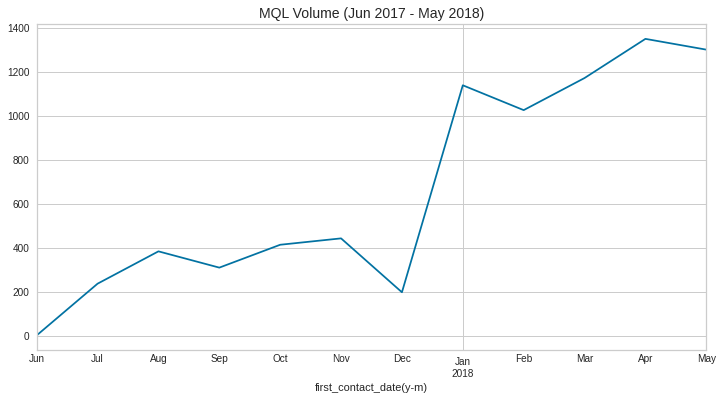

In [116]:
monthly_mql.plot.line(figsize=(12, 6))
plt.title('MQL Volume (Jun 2017 - May 2018)', fontsize=14);

In [119]:
mql_origin = pd.pivot_table(mf,
                            index='origin',
                            columns='first_contact_date(y-m)',
                            values='mql_id',                            
                            aggfunc='count',
                            fill_value=0)

# Sort index from largest to smallest in volume
origin_list = mf.groupby('origin').mql_id \
                                   .count() \
                                   .sort_values(ascending=False) \
                                   .index

mql_origin = mql_origin.reindex(origin_list)
mql_origin

first_contact_date(y-m)  2017-06  2017-07  2017-08  2017-09  2017-10  2017-11  \
origin                                                                          
organic_search                 0       54      122       78      125      121   
paid_search                    0       56       79       64      100       70   
social                         0       12       45       56       52       95   
unknown                        1       35       70       39       53       63   
direct_traffic                 0       16       22       22       23       26   
email                          1       19       24       23       30       37   
referral                       0        8       16       12        8       20   
other                          0       12        3        9        8        3   
display                        1       19        2        5        5        6   
other_publicities              0        3        2        4       11        3   

first_contact_date(y-m)  2017-12  2018-01  2018-02  2018-03  2018-04  2018-05  
origin                                                                         
organic_search                60      412      291      340      349      344  
paid_search                   35      170      212      262      272      266  
social                        39      162      156      139      325      269  
unknown                       25      151      156      186      166      154  
direct_traffic                10       82       65       80       75       78  
email                         12       61       68       74       50       94  
referral                       9       41       34       38       45       53  
other                          1       39       16       22       26       11  
display                        5       11       18       16       19       11  
other_publicities              1        7        5        8       12        9

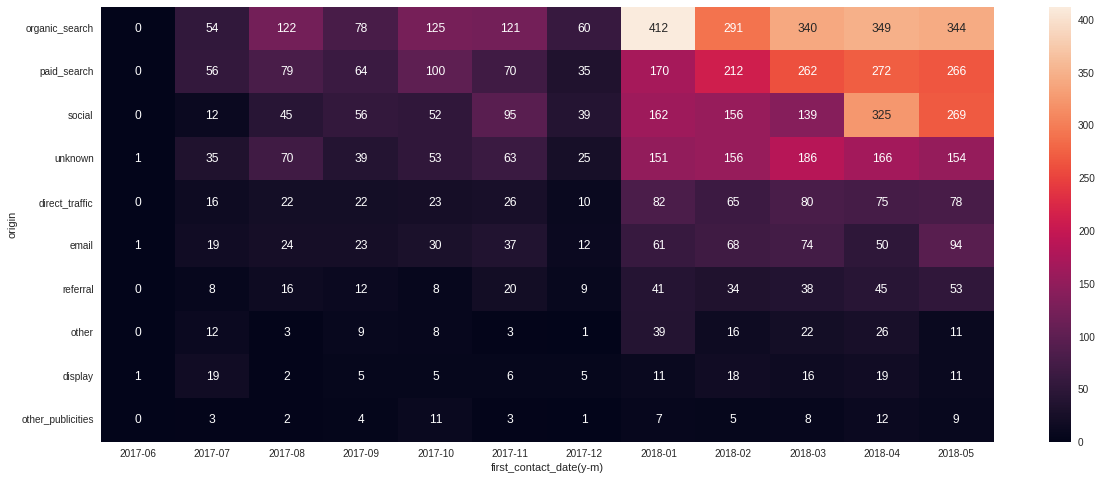

In [120]:
plt.figure(figsize=(20,8))
sns.heatmap(mql_origin, annot=True, fmt='g');

- Paid search is the second biggest contributor to lead generation after 'organic search'.
- The third one is 'social' which acquired MQLs more than or similar to 'paid search' since April 2018.
- If the marginal cost of paid search increases, it would be possible to examine effectiveness of 'social' as an alternative.

In [121]:
mf['seller_id(bool)'] = mf['seller_id'].notna()

print(mf.shape)
mf[['seller_id', 'seller_id(bool)']].head()

(8000, 19)


seller_id  seller_id(bool)
0                               NaN            False
1                               NaN            False
2                               NaN            False
3                               NaN            False
4  2c43fb513632d29b3b58df74816f1b06             True

In [122]:
monthly_cd = mf.groupby('first_contact_date(y-m)')['seller_id(bool)'].sum()
monthly_cd.to_frame().T

first_contact_date(y-m)  2017-06  2017-07  2017-08  2017-09  2017-10  2017-11  \
seller_id(bool)                0        2        9        7       14       18   

first_contact_date(y-m)  2017-12  2018-01  2018-02  2018-03  2018-04  2018-05  
seller_id(bool)               11      152      149      167      183      130

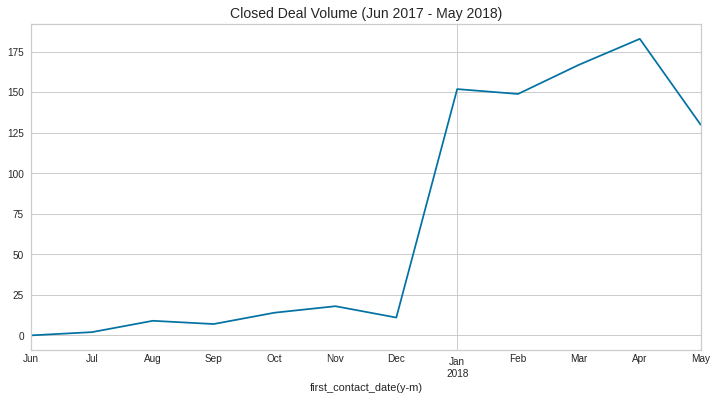

In [123]:
monthly_cd.plot.line(figsize=(12, 6))
plt.title('Closed Deal Volume (Jun 2017 - May 2018)', fontsize=14);

In [124]:
# Calculate monthly conversion rate
monthly_conversion = mf.groupby(by='first_contact_date(y-m)')['seller_id(bool)'].agg(['count', 'sum'])

monthly_conversion['conversion_rate(%)'] = ((monthly_conversion['sum'] / monthly_conversion['count']) * 100).round(1)
monthly_conversion.T

first_contact_date(y-m)  2017-06  2017-07  2017-08  2017-09  2017-10  2017-11  \
count                        4.0    239.0    386.0    312.0    416.0    445.0   
sum                          0.0      2.0      9.0      7.0     14.0     18.0   
conversion_rate(%)           0.0      0.8      2.3      2.2      3.4      4.0   

first_contact_date(y-m)  2017-12  2018-01  2018-02  2018-03  2018-04  2018-05  
count                      200.0   1141.0   1028.0   1174.0   1352.0   1303.0  
sum                         11.0    152.0    149.0    167.0    183.0    130.0  
conversion_rate(%)           5.5     13.3     14.5     14.2     13.5     10.0

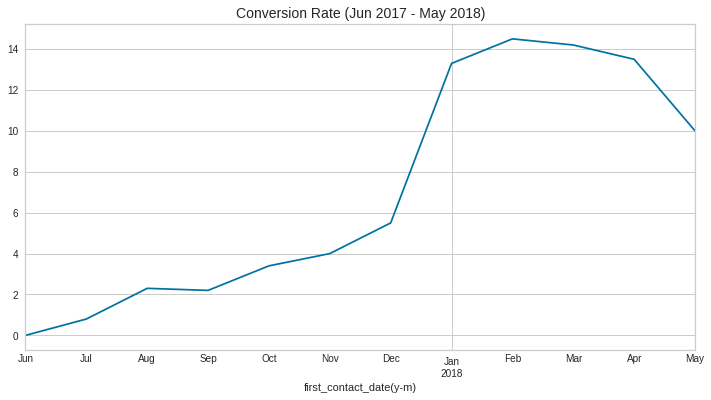

In [125]:
# Plot the monthly conversion rate
monthly_conversion['conversion_rate(%)'].plot.line(figsize=(12, 6))
plt.title('Conversion Rate (Jun 2017 - May 2018)', fontsize=14);

                   mql_id
origin                   
direct_traffic        499
display               118
email                 493
organic_search       2296
other                 150
other_publicities      65
paid_search          1586
referral              284
social               1350
unknown              1099


Text(0.5, 1.0, 'Number of MQL by channels overtime')

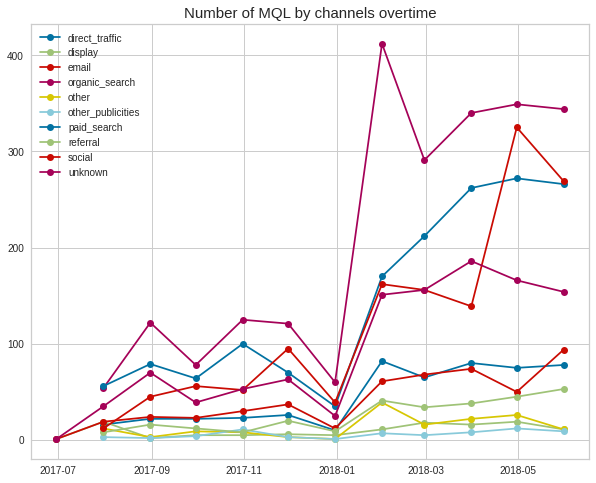

In [127]:
mql_origin = olist_marketing.groupby('origin').agg({'mql_id':'count'});print(mql_origin)
origin = list(mql_origin.index)
plt.figure(figsize = (10,8))
fancy_plot = plt.subplot()
for i in origin:
  channel = olist_marketing[olist_marketing['origin'] == i]
  channel = channel.set_index(pd.to_datetime(channel['first_contact_date']))
  channel_agg = channel.groupby(pd.Grouper(freq = 'M')).count().drop(axis = 1, columns =['first_contact_date', 'landing_page_id', 'origin'])
  fancy_plot.plot(channel_agg.index, channel_agg, '-o', label = i)
fancy_plot.legend()
plt.title('Number of MQL by channels overtime', size = 15)
# plt.savefig('channel-mql.png')